In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, XGBRegressor
import seaborn as sns
sns.set_style("dark")
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

#from warnings import filterwarnings
#filterwarnings('ignore')

data=None
def absolute_correlations(col, df=data):
    #absolute_values = np.abs(df[col])
    corrs = pd.DataFrame(df.select_dtypes(include=[np.number]).corrwith(df[col]), columns=['correlation'])
    corrs['absol'] = np.abs(corrs['correlation'])
    return corrs.sort_values('absol', ascending=False).drop('absol', axis=1).tail(len(corrs)-1)

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
loans = pd.read_csv('kiva_loans.csv')

loans.head(1)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,partner_id,posted_time,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date
0,653051,300.000,300.000,Fruits & Vegetables,Food,"To buy seasonal, fresh fruits to sell.",PK,Pakistan,Lahore,PKR,247.000,2014-01-01 06:12:39+00:00,2013-12-17 08:00:00+00:00,2014-01-02 10:06:32+00:00,12.000,12,NaN,female,irregular,2014-01-01


In [4]:
region = pd.read_csv('kiva_mpi_region_locations.csv')

print(region.shape)

region.head(1)

(2772, 9)


,LocationName,ISO,country,region,world_region,MPI,geo,lat,lon
0,"Badakhshan, Afghanistan",AFG,Afghanistan,Badakhshan,South Asia,0.387,"(36.7347725, 70.81199529999999)",36.735,70.812


In [5]:
loan_theme_ids = pd.read_csv('loan_theme_ids.csv')

print(loan_theme_ids.shape)

loan_theme_ids.head(1)

(779092, 4)


,id,Loan Theme ID,Loan Theme Type,Partner ID
0,638631,a1050000000skGl,General,151.000


In [6]:
loan_themes_byregion = pd.read_csv('loan_themes_by_region.csv')

print(loan_themes_byregion.shape)

loan_themes_byregion['region'].value_counts()

(15736, 21)


Chouf                                                 25
Nabatieh                                              23
Tripoli                                               23
Nablus                                                22
La UniÍ_n                                             21
San Vicente                                           21
Aley                                                  20
Nairobi                                               20
UsulutÍn                                             20
Saida                                                 19
Beirut                                                18
Spitamen                                              17
Qana                                                  17
Istaravshan                                           17
Kampala                                               16
Gaza City- Gaza Strip                                 16
Rafah city, Gaza Strip                                16
Dier Al-Balah, Gaza Strip      

In [7]:
data = pd.merge(loans, loan_theme_ids, on='id')
data = pd.merge(data, loan_themes_byregion, on='region')

In [8]:
countries = loans['country'].value_counts().head(50)
trace = go.Bar(
    y=countries.index[::-1],
    x=countries.values[::-1],
    orientation = 'h',
    marker=dict(
        color=countries.values[::-1],
        colorscale = 'Viridis',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Country wise distribution of loans',
    width=700,
    height=1000,
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="CountryLoan")

In [9]:
con_df = pd.DataFrame(loans['country'].value_counts()).reset_index()
con_df.columns = ['country', 'num_loans']
con_df = con_df.reset_index().drop('index', axis=1)

#Find out more at https://plot.ly/python/choropleth-maps/
data = [ dict(
        type = 'choropleth',
        locations = con_df['country'],
        locationmode = 'country names',
        z = con_df['num_loans'],
        text = con_df['country'],
        #colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(56, 142, 60)']],
        #colorscale = [[0,'rgb(255, 255, 255)'],[1,'rgb(220, 83, 67)']],
        colorscale = [[0,"rgb(5, 10, 172)"],[0.85,"rgb(40, 60, 190)"],[0.9,"rgb(70, 100, 245)"],\
            [0.94,"rgb(90, 120, 245)"],[0.97,"rgb(106, 137, 247)"],[1,"rgb(220, 220, 220)"]],
        autocolorscale = False,
        reversescale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'Number of Loans'),
      ) ]

layout = dict(
    title = 'Number of loans by Country',
    geo = dict(
        showframe = False,
        showcoastlines = True,
        projection = dict(
            type = 'Mercator'
        )
    )
)

fig = dict( data=data, layout=layout )
py.iplot( fig, validate=False, filename='loans-world-map')

In [10]:
sectors = loans['sector'].value_counts().head(25)
trace = go.Bar(
    y=sectors.index[::-1],
    x=sectors.values[::-1],
    orientation = 'h',
    marker=dict(
        color=sectors.values[::-1],
        colorscale = 'Viridis',
        reversescale = True
    ),
)

layout = dict(
    title='Sector wise distribution of loans',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="SectorLoan")

In [11]:
activities = loans['activity'].value_counts().head(25)
trace = go.Bar(
    y=activities.index[::-1],
    x=activities.values[::-1],
    orientation = 'h',
    marker=dict(
        color=activities.values[::-1],
        colorscale = 'Viridis',
        reversescale = True
    ),
)

layout = dict(
    title='Activity wise distribution of loans',
    )
data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="ActivityLoan")

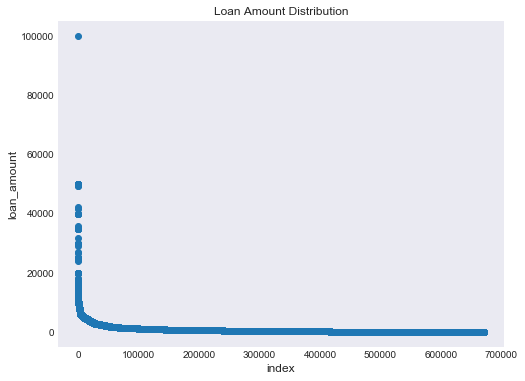

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(range(loans.shape[0]), [i for i in reversed(np.sort(loans.loan_amount.values))])
plt.xlabel('index', fontsize=12)
plt.ylabel('loan_amount', fontsize=12)
plt.title("Loan Amount Distribution")
plt.show()

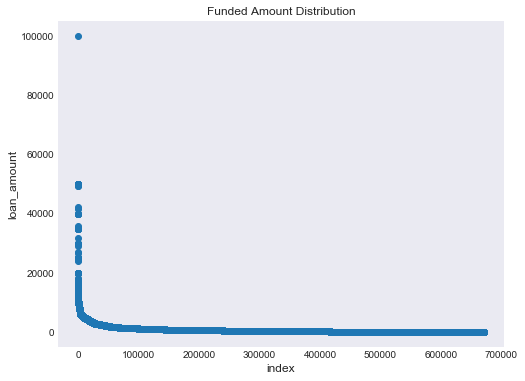

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(range(loans.shape[0]), [i for i in reversed(np.sort(loans.loan_amount.values))])
plt.xlabel('index', fontsize=12)
plt.ylabel('loan_amount', fontsize=12)
plt.title("Funded Amount Distribution")
plt.show()

C:\Users\vince\Anaconda3\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



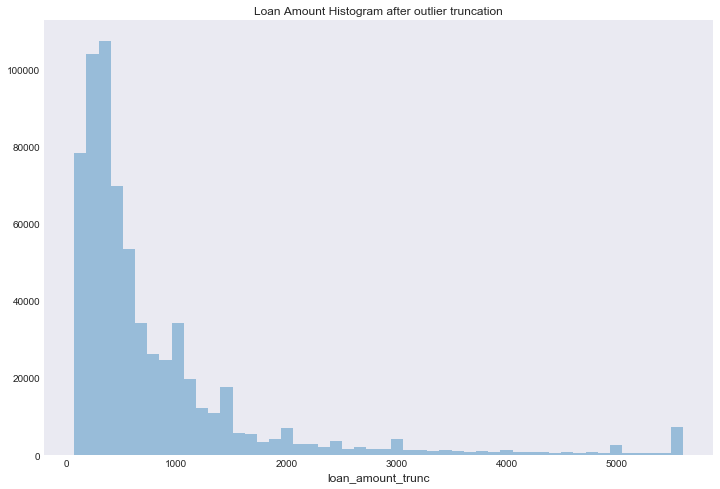

In [14]:
ulimit = np.percentile(loans.loan_amount.values, 99)
llimit = np.percentile(loans.loan_amount.values, 1)
loans['loan_amount_trunc'] = loans['loan_amount'].copy()
loans['loan_amount_trunc'].loc[loans['loan_amount'] > ulimit] = ulimit
loans['loan_amount_trunc'].loc[loans['loan_amount'] < llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(loans.loan_amount_trunc.values, bins=50, kde=False)
plt.xlabel('loan_amount_trunc', fontsize=12)
plt.title("Loan Amount Histogram after outlier truncation")
plt.show()

In [15]:
terms = loans.term_in_months.value_counts().head(40)

trace = go.Bar(
    x=terms.index,
    y=terms.values,
    marker=dict(
        color=terms.values,
        colorscale = 'Viridis',
        reversescale = True
    ),
)

layout = go.Layout(
    title='Repayment Term in Months'
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="RepaymentIntervals")

# Machine Learning

In [16]:
loans['y'] = (loans['loan_amount'] != loans['funded_amount']).astype(int)

loans.sample(20)

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,disbursed_time,funded_time,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,loan_amount_trunc,y
472673,1132645,200.000,200.000,Farming,Agriculture,to buy seeds to start farming so that she can ...,KE,Kenya,Kapsowar,KES,...,2016-08-08 07:00:00+00:00,2016-08-22 16:40:21+00:00,14.000,4,NaN,female,monthly,2016-08-12,200.000,0
178383,826890,300.000,300.000,Poultry,Agriculture,to buy additional poultry.,KE,Kenya,Kerugoya,KES,...,2015-01-05 08:00:00+00:00,2015-01-18 14:26:20+00:00,14.000,12,"#Animals, #Woman Owned Biz, #Parent, user_favo...",female,monthly,2015-01-12,300.000,0
614338,1275996,75.000,75.000,Farming,Agriculture,to hire labor for weeding and pruning her orga...,GH,Ghana,Akim-Abaam,GHS,...,2017-03-15 07:00:00+00:00,2017-04-22 10:26:31+00:00,17.000,3,"#Vegan, #Sustainable Ag, #Elderly, #Eco-friend...",female,irregular,2017-04-08,75.000,0
354712,1001521,1650.000,1650.000,Agriculture,Agriculture,to purchase materials to cover and protect his...,XK,Kosovo,NaN,EUR,...,2015-12-15 08:00:00+00:00,2016-01-27 14:14:13+00:00,22.000,59,"#First Loan, #Sustainable Ag, #Supporting Fami...",male,monthly,2015-12-29,1650.000,0
618380,1280152,400.000,400.000,Animal Sales,Agriculture,to purchase more calves to inflate her sales,PK,Pakistan,Bahawalpur,PKR,...,2017-03-17 07:00:00+00:00,2017-05-17 19:51:57+00:00,14.000,14,"#Woman Owned Biz, #Animals, #Biz Durable Asset...",female,monthly,2017-04-17,400.000,0
108965,759985,250.000,250.000,Retail,Retail,to buy more fruit to sell at her business,KE,Kenya,Keroka,KES,...,2014-08-21 07:00:00+00:00,2014-09-18 09:16:31+00:00,14.000,5,"#Parent, #Schooling, #Woman Owned Biz, #Vegan",female,monthly,2014-08-26,250.000,0
410184,1056528,500.000,500.000,Clothing Sales,Clothing,To invest in her clothing and sewing business.,PK,Pakistan,Rawalpindi,PKR,...,2016-03-21 07:00:00+00:00,2016-04-28 08:05:51+00:00,14.000,15,"#Fabrics, #Parent, #Woman Owned Biz, user_favo...",female,monthly,2016-04-19,500.000,0
407730,1054331,275.000,275.000,Food Market,Food,to buy more gallons of cooking oil to attend t...,GH,Ghana,"Teshie, Accra",GHS,...,2016-04-07 07:00:00+00:00,2016-04-19 04:06:44+00:00,7.000,10,NaN,female,irregular,2016-04-14,275.000,0
407219,1053378,400.000,400.000,Food Stall,Food,To help her son invest in his food stall busin...,PK,Pakistan,Rawalpindi,PKR,...,2016-03-13 08:00:00+00:00,2016-05-01 11:54:00+00:00,14.000,15,#Elderly,female,monthly,2016-04-13,400.000,0
463861,1123329,575.000,575.000,Rickshaw,Transportation,to help her her husband repair his rickshaw.,PK,Pakistan,Rawalpindi,PKR,...,2016-07-18 07:00:00+00:00,2016-09-02 18:10:37+00:00,14.000,18,#Repair Renew Replace,female,monthly,2016-07-26,575.000,0


In [17]:
del loans['disbursed_time']
del loans['funded_time']
del loans['funded_amount']
del loans['id']
del loans['country']
del loans['posted_time']
del loans['lender_count']
del loans['date']
del loans['loan_amount_trunc']

In [18]:
loans['num_borrowers'] = loans.borrower_genders.str.count(',')

In [19]:
x = loans.drop(['tags', 'use', 'partner_id', 'borrower_genders', 'y'], axis=1)
y = loans['y']

In [23]:
x = pd.get_dummies(x)

country_code


TypeError: unorderable types: float() < str()

In [ ]:
x = x.select_dtypes('number')

xtrain, xtest, ytrain, ytest = train_test_split(x,y, test_size=.2)

In [ ]:
from xgboost import XGBClassifier

clf = XGBClassifier()
params = {'max_depth': list(np.arange(2,5)),
         'reg_lambda': np.arange(1, 1.5, .1),
         'n_estimators': [100, 200, 300]}
grid = GridSearchCV(clf, param_grid=params, cv=4, scoring='roc_auc').fit(xtrain, ytrain)
clf = grid.best_estimator_

cv = cross_val_score(clf, xtrain, ytrain, cv=4, scoring='roc_auc')

print(clf, '\n')
print('Mean score:', cv.mean())
print('Std Dev:   ', cv.std())

In [ ]:
# Deep Learning

In [ ]:
#HANDLE MISSING VALUES
def handle_missing(dataset, cols):
    for col in cols:
        dataset[col].fillna(value="_LEFTBLANK_", inplace=True)
    return dataset

loans = handle_missing(loans, ['use', 'tags', 'activity', 'sector', 'country_code', 'currency'])

In [21]:
from sklearn.preprocessing import LabelEncoder

#PROCESS CATEGORICAL DATA
for i in 'activity sector country_code currency'.split():
    labeler = LabelEncoder()
    
    labeler.fit(loans[i])

    loans[i] = labeler.transform(loans[i])

TypeError: unorderable types: float() < str()

In [ ]:
repay = pd.get_dummies(loans['repayment_interval'])

loans = pd.concat([loans, repay], axis=1)
del loans['repayment_interval']

In [ ]:
loans['female_borrower'] = np.where(loans['borrower_genders'].str.contains('fe'), 1, 0)

In [ ]:
#PROCESS RAW TEXT
# 1. Gather raw text
# 2. Fit tokenizer to it
# 3. Convert item names and descriptions to token sequences

from keras.preprocessing.text import Tokenizer

print("Fitting tokenizer...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(loans['use'].str.lower())

print("Transforming text to seq...")
loans["loan_description"] = tokenizer.texts_to_sequences(loans['use'].str.lower())

In [ ]:
#PROCESS RAW TEXT
# 1. Gather raw text
# 2. Fit tokenizer to it
# 3. Convert item names and descriptions to token sequences

from keras.preprocessing.text import Tokenizer

print("Fitting tokenizer...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(loans['tags'].str.lower())

print("Transforming text to seq...")
loans["tag_seq"] = tokenizer.texts_to_sequences(loans['tags'].str.lower())

In [ ]:
#SEQUENCES VARIABLES ANALYSIS
loan_desc_len = loans["loan_description"].apply(len)
print("max desc seq:", loan_desc_len.max())

loan_tag_len = loans["tag_seq"].apply(len)
print("max tag seq:", loan_tag_len.max())

In [ ]:
# CREATE VALIDATION DATA
# y = loans.pop('y')
xtrain, xtest, ytrain, ytest = train_test_split(loans, y, test_size=.2)

print(xtrain.shape)
print(xtest.shape)

In [ ]:
#EMBEDDINGS MAX VALUE
#Base on the histograms, we select the next lengths

MAX_DESC_SEQ = 60
MAX_TAG_SEQ = 30

tokenizer.fit_on_texts(loans['use'].str.lower())
MAX_TOKEN = len(tokenizer.word_index) + 1
# 26207

MAX_ACTIVITY = np.max(loans.activity) + 1
MAX_SECTOR = np.max(loans.sector) + 1
MAX_COUNTRY = np.max(loans.country_code) + 1
MAX_CURRENCY = np.max(loans.currency) + 1

In [ ]:
# KERAS DATA DEFINITION
from keras.preprocessing.sequence import pad_sequences

def get_keras_data(dataset):
    X = {
        'loan_desc': pad_sequences(dataset.loan_description, maxlen=MAX_DESC_SEQ),
        'tag_desc': pad_sequences(dataset.tag_seq, maxlen=MAX_TAG_SEQ),
        'loans_activity': np.array(dataset.activity),
        'loans_sector': np.array(dataset.sector),
        'loans_country_code': np.array(dataset.country_code),
        'loans_currency': np.array(dataset.currency),
    }
    return X

# X
X_train = get_keras_data(xtrain)
X_val = get_keras_data(xtest)

# X_test = get_keras_data(test)

# Y
y_train = ytrain
y_val = ytest